In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sys
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts

In [2]:
#https://stackoverflow.com/questions/17211078/how-to-temporarily-modify-sys-path-in-python
#the above link is where i got this code.
#sys.path is restored to original state, after execution of the with statement
#importing sklearn from my directory INSTEAD of /public/apps/etc.etc. because mine is recent version
#apparently, this is called a context manager, visit above link for more explanation
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    sklearn = __import__('sklearn')

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# load Ray's excel file data into dataframes (please see what each df looks like below)

# i did some normalization, similar to how Caleb did in his HTML file. 

# note: i did NOT use Caleb's preprocessed csv files. I input my data directly from Ray's excel file

In [4]:
#be careful about using 'find and replace' in this cell
#taking excel file data and putting into dataframe, and creating new variable for each cell line, some modifications from Caleb's HTML file in here
mm231=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
mm231[mm231<0]=0
mm231=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mm231.shape[0])}),mm231.iloc[:,:4].div(mm231.iloc[:,:4].sum(axis=1),axis=0)],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mm231.shape[0])}),mm231.iloc[:,4:8].div(mm231.iloc[:,4:8].sum(axis=1),axis=0)],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,mm231.shape[0])}),mm231.iloc[:,8:].div(mm231.iloc[:,8:].sum(axis=1),axis=0)],axis=1)],axis=0)
mm231.insert(0,'cell_line',np.repeat('mm231',mm231.shape[0]))
mm231=mm231.reset_index(drop=True)
skbr3=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
skbr3[skbr3<0]=0
skbr3=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,skbr3.shape[0])}),skbr3.iloc[:,:4].div(skbr3.iloc[:,:4].sum(axis=1),axis=0)],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,skbr3.shape[0])}),skbr3.iloc[:,4:8].div(skbr3.iloc[:,4:8].sum(axis=1),axis=0)],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,skbr3.shape[0])}),skbr3.iloc[:,8:].div(skbr3.iloc[:,8:].sum(axis=1),axis=0)],axis=1)],axis=0)
skbr3.insert(0,'cell_line',np.repeat('skbr3',skbr3.shape[0]))
skbr3=skbr3.reset_index(drop=True)
mcf7=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
#taking care of some NaN values in the mcf7 dataframe
mcf7=pd.concat([mcf7.iloc[:,:4].fillna(method='bfill'),mcf7.iloc[:,4:]],axis=1).dropna(axis=0,how='any').reset_index(drop=True).astype(object).copy()
mcf7[mcf7<0]=0
mcf7=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mcf7.shape[0])}),mcf7.iloc[:,:4].div(mcf7.iloc[:,:4].sum(axis=1),axis=0)],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mcf7.shape[0])}),mcf7.iloc[:,4:8].div(mcf7.iloc[:,4:8].sum(axis=1),axis=0)],axis=1)],axis=0)
mcf7.insert(0,'cell_line',np.repeat('mcf7',mcf7.shape[0]))
mcf7=mcf7.reset_index(drop=True)


# without normalization

In [5]:
#be careful about using 'find and replace' in this cell
#taking excel file data and putting into dataframe, and creating new variable for each cell line, some modifications from Caleb's HTML file in here
mm231=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MM231inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
#mm231[mm231<0]=0
mm231=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mm231.shape[0])}),mm231.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mm231.shape[0])}),mm231.iloc[:,4:8]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,mm231.shape[0])}),mm231.iloc[:,8:]],axis=1)],axis=0)
mm231.insert(0,'cell_line',np.repeat('mm231',mm231.shape[0]))
mm231=mm231.reset_index(drop=True)
skbr3=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['SKBR3inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)

skbr3=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,skbr3.shape[0])}),skbr3.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,skbr3.shape[0])}),skbr3.iloc[:,4:8]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(3,skbr3.shape[0])}),skbr3.iloc[:,8:]],axis=1)],axis=0)
skbr3.insert(0,'cell_line',np.repeat('skbr3',skbr3.shape[0]))
skbr3=skbr3.reset_index(drop=True)
mcf7=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[1:].rename(columns=pd.read_excel('MulitplexSERS-CellLines_July_2020_RayShared.xlsx',engine='openpyxl',sheet_name=None)['MCF7inPBS'].dropna(axis=1,how='all').dropna(axis=0,how='all').iloc[0]).reset_index(drop=True)
#taking care of some NaN values in the mcf7 dataframe
mcf7=pd.concat([mcf7.iloc[:,:4].fillna(method='bfill'),mcf7.iloc[:,4:]],axis=1).dropna(axis=0,how='any').reset_index(drop=True).astype(object).copy()
#mcf7[mcf7<0]=0
mcf7=pd.concat([pd.concat([pd.DataFrame({'trial': np.repeat(1,mcf7.shape[0])}),mcf7.iloc[:,:4]],axis=1),
                pd.concat([pd.DataFrame({'trial': np.repeat(2,mcf7.shape[0])}),mcf7.iloc[:,4:8]],axis=1)],axis=0)
mcf7.insert(0,'cell_line',np.repeat('mcf7',mcf7.shape[0]))
mcf7=mcf7.reset_index(drop=True)


In [6]:
for trial in mm231.trial.unique():
    mm231.drop(mm231[mm231.trial==trial].index.max(),axis=0,inplace=True)
for trial in skbr3.trial.unique():
    skbr3.drop(skbr3[skbr3.trial==trial].index.max(),axis=0,inplace=True)
for trial in mcf7.trial.unique():
    mcf7.drop(mcf7[mcf7.trial==trial].index.max(),axis=0,inplace=True)

In [7]:
mm231

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,mm231,1,-0.0881312,0.104973,0.989479,0.00185108
1,mm231,1,0.131166,-0.156575,1.8554,0.0785188
2,mm231,1,-0.059342,0.0667256,0.59461,0.0432075
3,mm231,1,-0.113893,0.053339,0.68377,0.0239837
4,mm231,1,-0.0187563,0.168379,0.888258,0.0023825
...,...,...,...,...,...,...
147,mm231,3,0.089582,0.257064,1.13875,0.0131244
148,mm231,3,0.19277,-0.00378351,1.15843,0.0477611
149,mm231,3,0.222644,-0.12995,1.96731,0.0890588
150,mm231,3,0.25218,0.00560481,1.38762,0.0593045


In [8]:
skbr3

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,skbr3,1,-0.10999,0.652451,0.039156,0.067491
1,skbr3,1,-0.06618,0.230195,0.023738,-0.00276
2,skbr3,1,-0.07032,0.495735,0.033673,-0.01158
3,skbr3,1,0.283278,0.927984,0.119659,0.079347
4,skbr3,1,-0.00793,1.48431,0.194084,0.124917
...,...,...,...,...,...,...
147,skbr3,3,0.997588,1.40046,0.163618,0.0566113
148,skbr3,3,0.757674,0.962522,0.158397,-0.1049
149,skbr3,3,-0.0716846,0.925452,0.0734693,0.108263
150,skbr3,3,0.477565,1.31027,0.185903,0.124822


In [9]:
mcf7

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,mcf7,1,0.505908,0.0992778,0.349198,0.185024
1,mcf7,1,1.21,0.22128,0.305781,0.00655982
2,mcf7,1,0.69633,0.0699004,0.156289,0.156549
3,mcf7,1,0.309665,0.0092093,0.0707674,0.0658008
4,mcf7,1,0.548672,0.116571,0.374886,0.199617
...,...,...,...,...,...,...
96,mcf7,2,0.685291,0.155486,1.28309,0.190166
97,mcf7,2,0.400844,0.0256968,0.056572,0.0122257
98,mcf7,2,0.460165,0.0017038,0.111792,-0.0158494
99,mcf7,2,0.551926,0.0454891,0.12484,0.124258


In [10]:
mm231.trial.unique()

array([1, 2, 3])

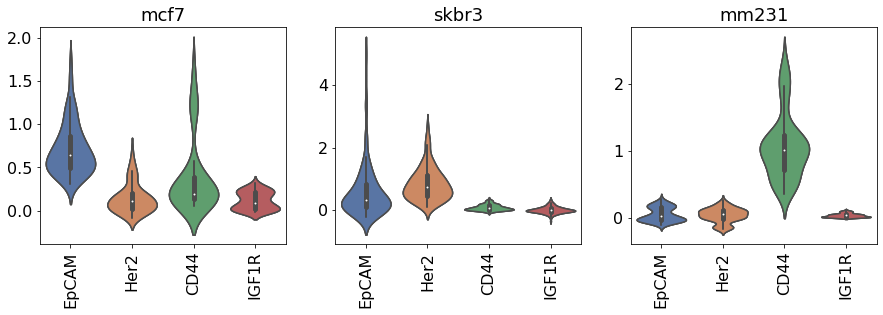

In [11]:
expression_data=['mcf7','skbr3','mm231']
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
j=0
for cell_line in expression_data:
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=mcf7.iloc[:,2:],
                           scale='width',
                         ax=axs[0])
    axs[0].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[0].tick_params(axis='y', labelsize=16)
    axs[0].set_title(str(mcf7.cell_line.unique()[0]), fontsize=18)
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=skbr3.iloc[:,2:],
                           scale='width',
                         ax=axs[1])
    axs[1].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[1].tick_params(axis='y', labelsize=16)
    axs[1].set_title(str(skbr3.cell_line.unique()[0]), fontsize=18)
    sns.set(style="whitegrid")
    ax=sns.violinplot(data=mm231.iloc[:,2:],
                           scale='width',
                         ax=axs[2])
    axs[2].set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
    axs[2].tick_params(axis='y', labelsize=16)
    axs[2].set_title(str(mm231.cell_line.unique()[0]), fontsize=18)
    

In [12]:
combined=pd.concat([mcf7,skbr3,mm231],axis=0)

In [13]:
mcf7_vertical=pd.DataFrame(data=np.repeat(mcf7.cell_line.unique()[0].upper(),
                                          mcf7['EpCAM'].shape[0]+mcf7['Her2'].shape[0]+mcf7['CD44'].shape[0]+mcf7['IGF1R'].shape[0]),columns=['cell_line'])
mcf7_vertical['marker']=np.concatenate(np.array([np.repeat('EpCAM',mcf7['EpCAM'].shape[0]),
                         np.repeat('Her2'.upper(),mcf7['Her2'].shape[0]),
                        np.repeat('CD44',mcf7['CD44'].shape[0]),
                        np.repeat('IGF1R',mcf7['IGF1R'].shape[0])]),axis=0)
mcf7_vertical['expression']=np.concatenate(np.array([mcf7.EpCAM.values,
                                                     mcf7.Her2.values,
                                                    mcf7.CD44.values,
                                                    mcf7.IGF1R.values]),axis=0)
skbr3_vertical=pd.DataFrame(data=np.repeat(skbr3.cell_line.unique()[0].upper(),
                                          skbr3['EpCAM'].shape[0]+skbr3['Her2'].shape[0]+skbr3['CD44'].shape[0]+skbr3['IGF1R'].shape[0]),columns=['cell_line'])
skbr3_vertical['marker']=np.concatenate(np.array([np.repeat('EpCAM',skbr3['EpCAM'].shape[0]),
                         np.repeat('Her2'.upper(),skbr3['Her2'].shape[0]),
                        np.repeat('CD44',skbr3['CD44'].shape[0]),
                        np.repeat('IGF1R',skbr3['IGF1R'].shape[0])]),axis=0)
skbr3_vertical['expression']=np.concatenate(np.array([skbr3.EpCAM.values,
                                                     skbr3.Her2.values,
                                                    skbr3.CD44.values,
                                                    skbr3.IGF1R.values]),axis=0)
mm231_vertical=pd.DataFrame(data=np.repeat(mm231.cell_line.unique()[0].upper(),
                                          mm231['EpCAM'].shape[0]+mm231['Her2'].shape[0]+mm231['CD44'].shape[0]+mm231['IGF1R'].shape[0]),columns=['cell_line'])
mm231_vertical['marker']=np.concatenate(np.array([np.repeat('EpCAM',mm231['EpCAM'].shape[0]),
                         np.repeat('Her2'.upper(),mm231['Her2'].shape[0]),
                        np.repeat('CD44',mm231['CD44'].shape[0]),
                        np.repeat('IGF1R',mm231['IGF1R'].shape[0])]),axis=0)
mm231_vertical['expression']=np.concatenate(np.array([mm231.EpCAM.values,
                                                     mm231.Her2.values,
                                                    mm231.CD44.values,
                                                    mm231.IGF1R.values]),axis=0)
combined_vertical=pd.concat([mcf7_vertical,
                            skbr3_vertical,
                            mm231_vertical],axis=0)
combined_vertical['expression']=combined_vertical['expression'].astype('float64')


[None, None, None, None, None, None]

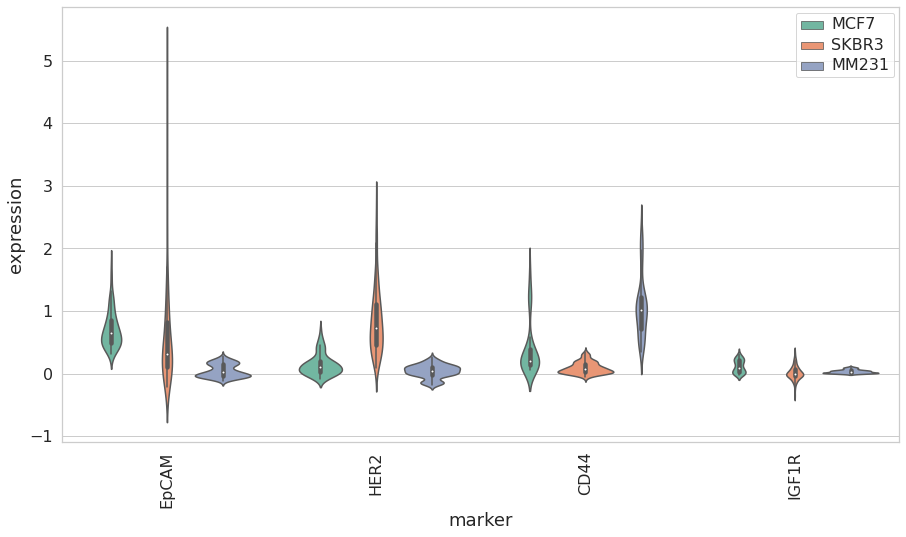

In [14]:
fig,ax = plt.subplots(figsize=(15,8))
ax=sns.violinplot(x='marker', y='expression', hue='cell_line',
                    data=combined_vertical, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
x_label=ax.get_xlabel()
y_label=ax.get_ylabel()
ax.set_xlabel(x_label, fontsize=18)
ax.set_ylabel(y_label, fontsize=18)
ax.tick_params(axis='y', labelsize=16)
legend = ax.legend()
#legend.texts[0].set_text("Cell Lines")
plt.setp(ax.get_legend().get_texts(), fontsize='16')
#plt.savefig('all_cell_lines_marker.jpg', dpi = 500, bbox_inches='tight')

In [15]:
combined_vertical

,cell_line,marker,expression
0,MCF7,EpCAM,0.505908
1,MCF7,EpCAM,1.210003
2,MCF7,EpCAM,0.696330
3,MCF7,EpCAM,0.309665
4,MCF7,EpCAM,0.548672
...,...,...,...
595,MM231,IGF1R,0.013124
596,MM231,IGF1R,0.047761
597,MM231,IGF1R,0.089059
598,MM231,IGF1R,0.059304


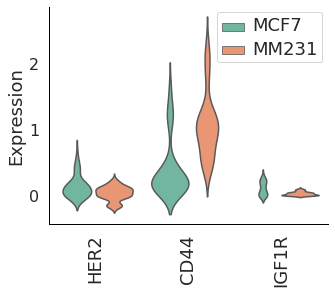

In [24]:
#combined_vertical[(combined_vertical['cell_line']=='mcf7') | (combined_vertical['cell_line']=='skbr3')]
data=combined_vertical[((combined_vertical['cell_line']=='MM231') | (combined_vertical['cell_line']=='MCF7')) & (combined_vertical['marker']!='EpCAM') ]
fig,ax = plt.subplots(figsize=(5,4))
Means = data.groupby('marker')['expression'].mean()
ax=sns.violinplot(x='marker', y='expression', hue='cell_line',inner=None,
                    data=data, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_color('black')
    ax.spines[axis].set_linewidth(1)
ax.spines[['right', 'top']].set_visible(False)

x_label=ax.get_xlabel()
y_label=ax.get_ylabel()
ax.set_xlabel(None)
ax.set_ylabel('Expression', fontsize=18)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=18)
legend = ax.legend(loc='upper right')
ax.grid(False)

#legend.texts[0].set_text("Cell Lines")
plt.setp(ax.get_legend().get_texts(), fontsize='18')
plt.savefig(data.cell_line.unique()[0]+'_'+data.cell_line.unique()[1]+'_marker.jpg', dpi = 1000, bbox_inches='tight')


# creating new dataframes for trial 1 (all cell lines) and trial 2 (all cell lines)

In [233]:
trial_1_all_cells=pd.concat([mm231[mm231.trial==1],skbr3[skbr3.trial==1],mcf7[mcf7.trial==1]],axis=0).reset_index(drop=True)
trial_2_all_cells=pd.concat([mm231[mm231.trial==2],skbr3[skbr3.trial==2],mcf7[mcf7.trial==2]],axis=0).reset_index(drop=True)
trial_3_all_cells=pd.concat([mm231[mm231.trial==3],skbr3[skbr3.trial==3]],axis=0).reset_index(drop=True)


In [234]:
trial_1_all_cells

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,mm231,1,0,0.0957518,0.90256,0.00168848
1,mm231,1,0.0635159,0,0.898462,0.0380221
2,mm231,1,0,0.0947076,0.843965,0.061327
3,mm231,1,0,0.0700821,0.898406,0.0315121
4,mm231,1,0,0.158995,0.838755,0.00224972
...,...,...,...,...,...,...
148,mcf7,1,0.311975,0.060989,0.513151,0.113885
149,mcf7,1,0.439772,0.101803,0.298202,0.160223
150,mcf7,1,0.620397,0.266148,0.0850021,0.0284532
151,mcf7,1,0.686297,0.135821,0.172461,0.00542135


In [235]:
trial_2_all_cells

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,mm231,2,0,0.0566051,0.919197,0.0241981
1,mm231,2,0,0.104093,0.892499,0.00340843
2,mm231,2,0,0.112196,0.882157,0.00564663
3,mm231,2,0.123304,0,0.843213,0.033483
4,mm231,2,0,0.0947847,0.869742,0.0354736
...,...,...,...,...,...,...
148,mcf7,2,0.809233,0.0518773,0.114209,0.0246814
149,mcf7,2,0.802156,0.00297004,0.194874,0
150,mcf7,2,0.651999,0.053737,0.147476,0.146788
151,mcf7,2,0.617229,0.27006,0.0841231,0.0285873


In [236]:
trial_3_all_cells

,cell_line,trial,EpCAM,Her2,CD44,IGF1R
0,mm231,3,0.0845422,0,0.876486,0.0389713
1,mm231,3,0,0.117711,0.874793,0.00749605
2,mm231,3,0.132059,0,0.833297,0.0346443
3,mm231,3,0,0.102855,0.859579,0.0375661
4,mm231,3,0.0750871,0.11557,0.756263,0.0530798
...,...,...,...,...,...,...
97,skbr3,3,0.40332,0.512363,0.0843168,0
98,skbr3,3,0,0.835861,0.0663568,0.0977822
99,skbr3,3,0.227567,0.624367,0.0885861,0.0594798
100,skbr3,3,0.0268716,0.791702,0.10994,0.0714861


In [237]:
#CONVERTING cell_line column to numbers. 0,1,2 for three different cell lines
factor = pd.factorize(trial_1_all_cells['cell_line'])
#trial_1_all_cells.cell_line = factor[0]
definitions = factor[1]
reversefactor = dict(zip(range(3),definitions))
#factor = pd.factorize(trial_2_all_cells['cell_line'])
#trial_2_all_cells.cell_line = factor[0]
#definitions = factor[1]
#print(trial_1_all_cells.cell_line.head())
#print(definitions)

In [238]:
reversefactor

{0: 'mm231', 1: 'skbr3', 2: 'mcf7'}

# doing random forest classifier. training set is the trial 1 data and multiple test sets. see below

In [239]:
#training on on trial 1 all 3 cell lines, and testing on trial 2 all three cell lines
X=trial_1_all_cells[['EpCAM','Her2','CD44','IGF1R']]
y=trial_1_all_cells['cell_line']
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X,y)
y_pred = classifier.predict(trial_2_all_cells[['EpCAM','Her2','CD44','IGF1R']])
#reversefactor = dict(zip(range(3),definitions))

print("The classifier Accuracy: ", accuracy_score(trial_2_all_cells['cell_line'],y_pred))
feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
print(feature_importances_df)



The classifier Accuracy:  0.9934640522875817
  feature  importance
2    CD44    0.512054
1    Her2    0.278422
0   EpCAM    0.164198
3   IGF1R    0.045326


# which specific entry or entries were wrongly predicted? i go entry by entry to find out which one it is.

In [240]:
#which specific entries are wrongly predicted?
j=0
for entry_pred,entry_true in zip(y_pred,trial_2_all_cells['cell_line']):
    if entry_pred!=entry_true:
        print('the predicted cell line is: ')
        print(entry_pred)
        print('& the actual cell line is: ')
        print(entry_true)
        print('The index value: ')
        print(j)
        print('more details about the true cell line value:')
        print(trial_2_all_cells.loc[j])
    j+=1    


the predicted cell line is: 
skbr3
& the actual cell line is: 
mcf7
The index value: 
144
more details about the true cell line value:
cell_line         mcf7
trial                2
EpCAM         0.548998
Her2          0.288849
CD44           0.14703
IGF1R        0.0151233
Name: 144, dtype: object


In [241]:
print('for all the misidentified entries, it seems mcf7 is identified to be skbr3')
print('i cannot tell why the misidentification is happening')

for all the misidentified entries, it seems mcf7 is identified to be skbr3
i cannot tell why the misidentification is happening


# Reproducing the expression values from Caleb's HTML file. Note i DID NOT use Caleb's preprocessed csv files, i directly input my data from Ray's excel file

Text(0.5, 1.0, 'mm231')

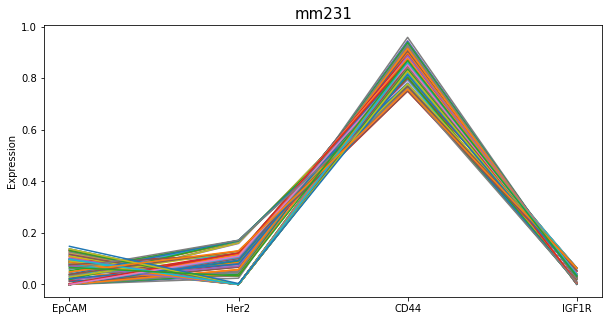

In [242]:
#code modified from caleb's HTML file
#mm231 expression in all trials
fig,ax = plt.subplots(figsize = (10,5))
cell_line = "mm231"
ax.plot(mm231.loc[mm231.cell_line.values==cell_line,:].drop('cell_line',axis=1).drop('trial',axis=1).T,label=cell_line)
ax.set_ylabel("Expression")
#ax.set_ylim(0,1)
ax.set_title(cell_line,fontsize=15)


Text(0.5, 1.0, 'skbr3')

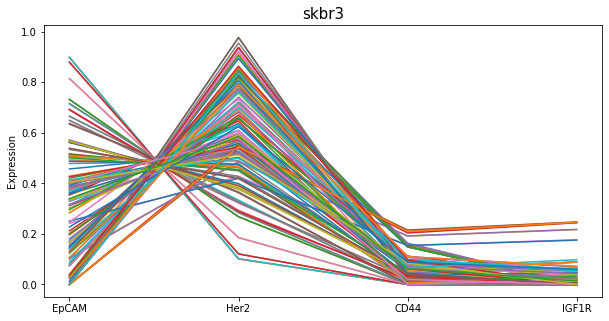

In [243]:
#code modified from caleb's HTML file
#skbr3 expression in all trials
fig,ax = plt.subplots(figsize = (10,5))
cell_line = "skbr3"
ax.plot(skbr3.loc[skbr3.cell_line.values==cell_line,:].drop('cell_line',axis=1).drop('trial',axis=1).T,label=cell_line)
ax.set_ylabel("Expression")
#ax.set_ylim(0,1)
ax.set_title(cell_line,fontsize=15)

Text(0.5, 1.0, 'mcf7')

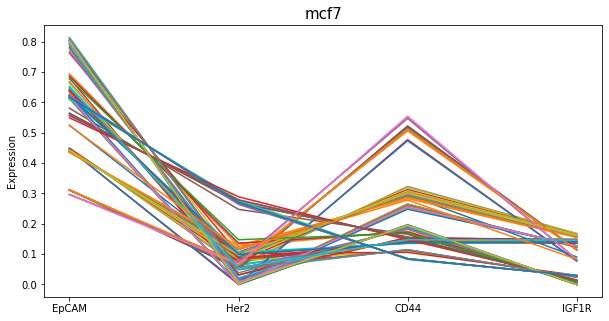

In [244]:
#code modified from caleb's HTML file
#mcf7 expression in all trials
fig,ax = plt.subplots(figsize = (10,5))
cell_line = "mcf7"
ax.plot(mcf7.loc[mcf7.cell_line.values==cell_line,:].drop('cell_line',axis=1).drop('trial',axis=1).T,label=cell_line)
ax.set_ylabel("Expression")
#ax.set_ylim(0,1)
ax.set_title(cell_line,fontsize=15)

# some more test sets

In [245]:
#THIS IS TRIAL 3 of MM231
test_2nd_df=mm231.copy()
#factor = pd.factorize(test_2nd_df['cell_line'])
#test_2nd_df['cell_line'] = factor[0]
#definitions = factor[1]
y_pred_2nd=classifier.predict(test_2nd_df[test_2nd_df.trial==3].iloc[:,2:])
print("The classifier Accuracy: ", accuracy_score(test_2nd_df[test_2nd_df.trial==3]['cell_line'],y_pred_2nd))

The classifier Accuracy:  1.0


In [246]:
#THIS IS TRIAL 2 of MM231
test_3rd_df=mm231.copy()
#factor = pd.factorize(test_3rd_df['cell_lie'])
#test_3rd_df['cell_line'] = factor[0]
#definitions = factor[1]
y_pred_3rd=classifier.predict(test_3rd_df[test_3rd_df.trial==2].iloc[:,2:])
print("The classifier Accuracy: ", accuracy_score(test_3rd_df[test_3rd_df.trial==2]['cell_line'],y_pred_3rd))

The classifier Accuracy:  1.0


In [247]:
#THIS IS TRIAL 3 of skbr3
test_4th_df=skbr3.copy()
#factor = pd.factorize(test_4th_df['cell_lie'])
#test_4th_df['cell_line'] = factor[0]
#definitions = factor[1]
y_pred_4th=classifier.predict(test_4th_df[test_4th_df.trial==3].iloc[:,2:])
print("The classifier Accuracy: ", accuracy_score(test_4th_df[test_4th_df.trial==3]['cell_line'],y_pred_4th))

The classifier Accuracy:  1.0


# changing it up. Doing train test split 50:50

In [248]:
X=pd.concat([mm231,skbr3,mcf7])[['EpCAM','Her2','CD44','IGF1R']]
y=pd.concat([mm231,skbr3,mcf7])['cell_line']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("The classifier Accuracy: ", accuracy_score(y_test,y_pred))
feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
print(feature_importances_df)


The classifier Accuracy:  0.9950980392156863
  feature  importance
2    CD44    0.403938
1    Her2    0.351190
0   EpCAM    0.193743
3   IGF1R    0.051129


# this is the one vs rest ROC. But not sure if one vs rest is the best one to show ROC here

# ROC is based on trial 1 as training set

In [220]:
#using same training sets as before
X=trial_1_all_cells[['EpCAM','Her2','CD44','IGF1R']]
y=pd.factorize(trial_1_all_cells['cell_line'])[0]
#using pipline to do the random forest fit
pipe_rf = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
model = pipe_rf.fit(X, y)
#calculate a probability score for the 3 different cell lines
y_score = model.predict_proba(trial_2_all_cells[['EpCAM','Her2','CD44','IGF1R']])
y_test_bin = label_binarize(pd.factorize(trial_2_all_cells['cell_line'])[0],classes=pd.factorize(trial_2_all_cells['cell_line'].unique())[0])
n_classes = y_test_bin.shape[1]


AUC for Class 1: 1.0
AUC for Class 2: 1.0
AUC for Class 3: 1.0


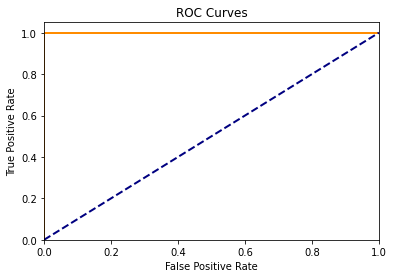

In [221]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

# do cross validation scores, 10-fold and 4-fold

# the cross validation scores are all 1.0

In [223]:
X=trial_1_all_cells[['EpCAM','Her2','CD44','IGF1R']]
y=pd.factorize(trial_1_all_cells['cell_line'])[0]
#construct baseline pipeline
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X,y)
y_pred = classifier.predict(trial_2_all_cells[['EpCAM','Her2','CD44','IGF1R']])

print(np.mean(cross_val_score(classifier, X, y, cv=10)))


1.0


In [224]:
X=trial_1_all_cells[['EpCAM','Her2','CD44','IGF1R']]
y=pd.factorize(trial_1_all_cells['cell_line'])[0]
#construct baseline pipeline
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X,y)
y_pred = classifier.predict(trial_2_all_cells[['EpCAM','Her2','CD44','IGF1R']])

print(np.mean(cross_val_score(classifier, X, y, cv=4)))


1.0
